# Import Section

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Sklearn import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

# Typing import
from typing import Tuple

# Const declaration

In [226]:
TITANIC_DATASET_PATH = "./titanic/train.csv"
TITANIC_DATASET_TEST_PATH = "./titanic/test.csv"
SUBMISSION_PATH = "./titanic/submission.csv"
N_JOB = os.cpu_count() - 1

# Open the data and split it
As there are not the same amount of female and male, I will stratified the train and test set base on this feature

In [181]:
titanic_df = pd.read_csv(TITANIC_DATASET_PATH)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [182]:
X_train = titanic_df.drop("Survived", axis=1)
X_train.set_index("PassengerId")
y_train = titanic_df["Survived"].copy()

# Data exploration
As we are already know, there are twice mens as women on the ship, but let's seek more pattern that could be useful

### The signification of the data
| DF Name  | Meaning                                    | Values                                            |
|----------|--------------------------------------------|---------------------------------------------------|
| survival | 	Survival                                  | 	           0 = No, 1 = Yes                       |
| pclass	  | Ticket class                               | 	       1 = 1st, 2 = 2nd, 3 = 3rd                 |
| sex	     | Sex	                                       | Male or female                                    |
| Age	     | Age in years                               | --                                                |
| sibsp	   | # of siblings / spouses aboard the Titanic | --                                                |
| parch	   | # of parents / children aboard the Titanic | --                                                |
| ticket	  | Ticket number                              | --                                                |
| fare	    | Passenger fare                             | --                                                |
| cabin	   | Cabin number                               | --                                                |
| embarked | Port of Embarkation                        | 	  C = Cherbourg, Q = Queenstown, S = Southampton |

Quite a lot of interesting colums, it could be useful to see if there is any hard correlation between
- Sex and Target
- Age and Target
- Fare and Target
- Maybe Embarked and Target (The cabin may depend on the embarcation port)
- If there is a lot of family member on the ship

However, Cabin seems laking of data and can be hard to fill, Age also, but can be treated through a pipeline and choses between mean or median. Ticket name could also get a correlation with the cabin number, but not seems to useful as it's own to predict the target value

In [153]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [154]:
X_train.describe().round()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,2.0,30.0,1.0,0.0,32.0
std,257.0,1.0,15.0,1.0,1.0,50.0
min,1.0,1.0,0.0,0.0,0.0,0.0
25%,224.0,2.0,20.0,0.0,0.0,8.0
50%,446.0,3.0,28.0,0.0,0.0,14.0
75%,668.0,3.0,38.0,1.0,0.0,31.0
max,891.0,3.0,80.0,8.0,6.0,512.0


In [155]:
X_train["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [156]:
X_train["Ticket"].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [157]:
X_train["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [158]:
X_train["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

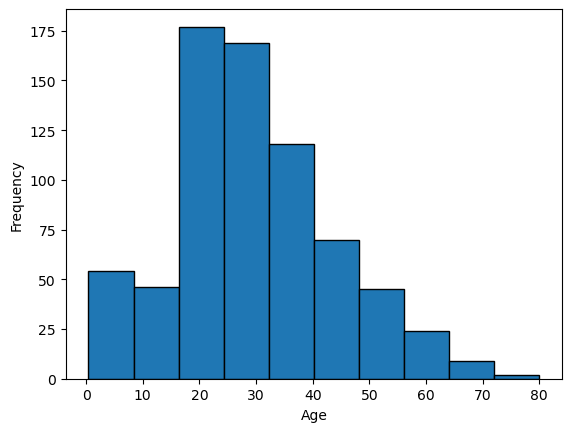

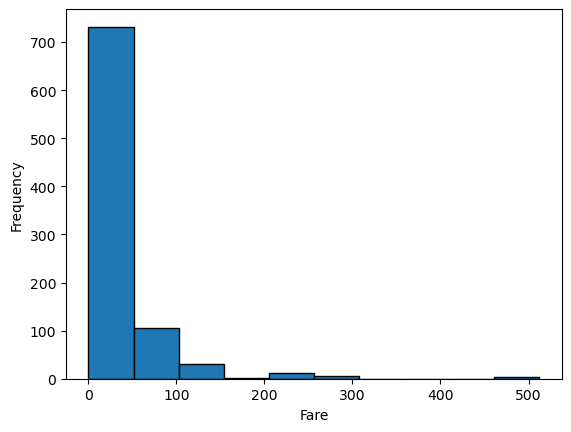

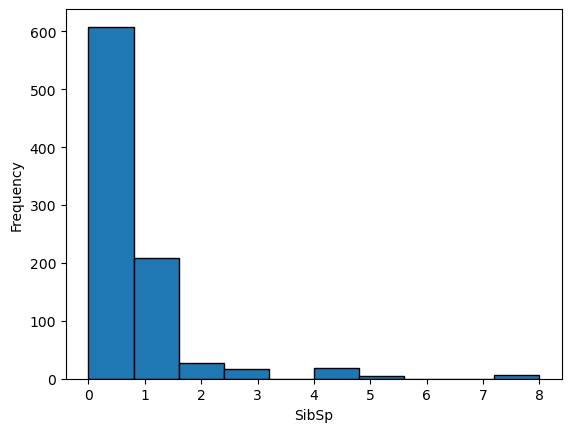

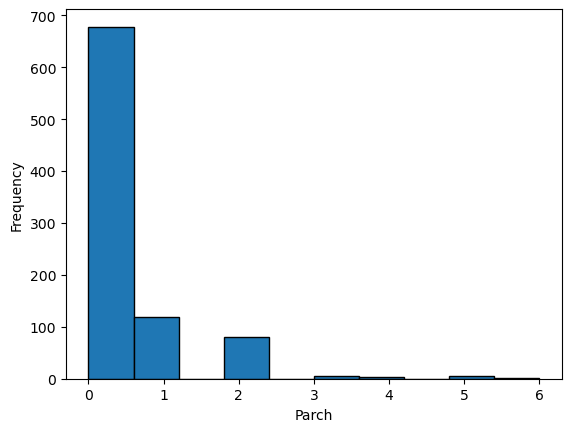

In [160]:
num_cols = ["Age", "Fare", "SibSp", "Parch"]

for num_col in num_cols:
    plt.hist(X_train[num_col], edgecolor='black')

    plt.xlabel(num_col)
    plt.ylabel('Frequency')
    plt.show()

In [161]:
X_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

# Creating Pipelines


In [183]:
def get_first_letter(X):
    return np.array([[x[0][0] for x in X]]).reshape(-1, 1)

def get_first_letter_outcolumns_name(function_transformer, feature_name_in):
    return ["initial_cabine"]

cabin_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="Z"),
    FunctionTransformer(get_first_letter, feature_names_out=get_first_letter_outcolumns_name),
    OneHotEncoder(handle_unknown="ignore")
)

In [184]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class AgeImputer(BaseEstimator, TransformerMixin):
    def impute_age(self, row):
        if pd.isnull(row["Age"]):
            return self.class_means_[row['Pclass']]
        else:
            return row["Age"]

    def fit(self, X: pd.DataFrame, y: pd.DataFrame | None=None):
        self.feature_names_in_ = X.columns
        self.n_features_in_ = X.shape[1]
        self.class_means_ = X.groupby('Pclass')["Age"].mean()
        return self

    def transform(self, X: pd.DataFrame, y: pd.DataFrame | None=None) -> np.ndarray:
        check_is_fitted(self)
        X["Age"] = X.apply(self.impute_age, axis=1)
        return X


    def get_feature_names_out(self, input_features: list | None = None) -> list:
        return self.feature_names_in_

In [185]:
age_pipeline = make_pipeline(
    AgeImputer(),
    StandardScaler()
)
default_cat_pipelines = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)
default_num_pipelines = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [200]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
    ("age", age_pipeline, ["Age", "Pclass"]),
    ("cabin", cabin_pipeline, ["Cabin"]),
    ("num", default_num_pipelines, ["Pclass", "SibSp", "Parch", "Fare"]),
    ("cat", default_cat_pipelines, ["Sex", "Embarked"]),
])

In [202]:
class DropColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if not hasattr(X, "column"):
            X = pd.DataFrame(X, columns=preprocessing.get_feature_names_out())
        columns = X.columns
        if "Name" in columns:
            X.drop("Name", axis=1, inplace=True)
        if "Ticket" in columns:
            X.drop("Ticket", axis=1, inplace=True)
        if "age__Pclass" in columns:
            X.drop("age__Pclass", axis=1, inplace=True)
        return X


In [220]:
from sklearn.pipeline import Pipeline

pipelines = Pipeline([
    ("preprocessing", preprocessing),
    ("drop_columns", DropColumns()),
])

In [221]:
tr_df = pipelines.fit_transform(X_train, y_train)

In [222]:
tr_df

,age__Age,cabin__initial_cabine_A,cabin__initial_cabine_B,cabin__initial_cabine_C,cabin__initial_cabine_D,cabin__initial_cabine_E,cabin__initial_cabine_F,cabin__initial_cabine_G,cabin__initial_cabine_T,cabin__initial_cabine_Z,num__Pclass,num__SibSp,num__Parch,num__Fare,cat__Sex_0.0,cat__Sex_1.0,cat__Embarked_0.0,cat__Embarked_1.0,cat__Embarked_2.0
0,-0.552360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.827377,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,0.659475,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.566107,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,-0.249401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.827377,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,0.432256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.566107,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.432256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.827377,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.173662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.369365,-0.474545,-0.473674,-0.386671,0.0,1.0,0.0,0.0,1.0
887,-0.779579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.566107,-0.474545,-0.473674,-0.044381,1.0,0.0,0.0,0.0,1.0
888,-0.314491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.827377,0.432793,2.008933,-0.176263,1.0,0.0,0.0,0.0,1.0
889,-0.249401,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.566107,-0.474545,-0.473674,-0.044381,0.0,1.0,1.0,0.0,0.0


In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(random_state=42)
clf_score = cross_val_score(clf, tr_df, y_train, cv=10, scoring="accuracy")

In [207]:
np.mean(clf_score)

0.8126342072409487

In [208]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, tr_df, y_train, cv=10)
svm_scores.mean()

0.8204369538077405

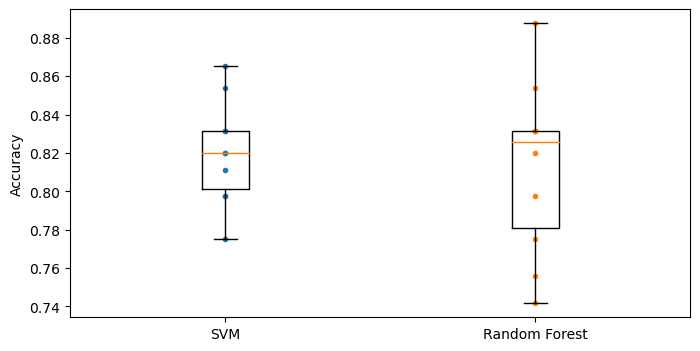

In [209]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, clf_score, ".")
plt.boxplot([svm_scores, clf_score], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# param_grid = {'bootstrap': [True, False],
#                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
#
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42, max_features="sqrt"), param_grid=param_grid, cv=10, scoring="accuracy", verbose=2, n_jobs=N_JOB)
# grid_res = grid_search.fit(tr_df, y_train)

In [213]:
# grid_res.best_score_

0.8350312109862672

In [214]:
# grid_res.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [215]:
best_params = {'bootstrap': False,
               'max_depth': 10,
               'min_samples_leaf': 1,
               'min_samples_split': 10,
               'n_estimators': 200}

In [216]:
clf = RandomForestClassifier(random_state=42, max_features="sqrt", **best_params)
clf.fit(tr_df, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [223]:
test_df = pd.read_csv(TITANIC_DATASET_TEST_PATH)
test_tr_df = pipelines.transform(test_df)

In [224]:
pred = clf.predict(test_tr_df)

In [225]:
pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [234]:
sub = test_df[["PassengerId"]].copy()
sub['Survived'] = pred
sub.to_csv(SUBMISSION_PATH, index = False)